# Solution Notebook with Grading Guidance
# Models of Higher Brain Functions - Computer Practical¶
## Learning Dynamics in Deep Linear Networks' - November 2019 - TU Berlin

### Notes for next time
- Make sd in matrix init to 0.01 not variance! Very different learning dynamics
- Make more extensive deep learning part

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy.linalg import svd as svd
import matplotlib.pyplot as plt

from plot_helpers import *

np.random.seed(1)

# Exc 1: Singular Value Mode Convergence (10 Points)
In the following we replicate figure 3c from the main paper (Saxe et al. 2019, p. 3). This includes the simulation check of the theoretical results on the convergence of the different singular value modes for the single hidden-layer as well as the shallow network case.

Structure of the code:
0. Generate the toy data from Saxe et al. 19'
1. Implement the continuous time mean epoch update equations
    - 1-hidden layer network $\to$ **1 Point**
    - Shallow network $\to$ **1 Point**
2. Run the learning loop with the specified parameters & get singular values and plot them
    - Setup the learning loop $\to$ **1 Point**
    - Calculate the SVD $\to$ **1 Point**
    - Plot the results $\to$ **1 Point**
    - Comparison of shallow and deep network in convergence dynamics $\to$ **1 Point**
3. Implement the exact equations for the singular value dynamics
    - 1-hidden layer network $\to$ **1 Point**
    - Shallow network $\to$ **1 Point** 
    - Plot the results $\to$ **1 Point**
    - Comparison of analytics and simulation $\to$ **1 Point**

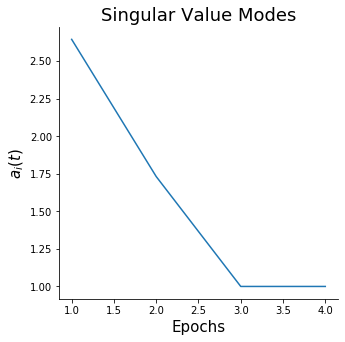

In [2]:
"""
Generate the toy data (Saxe et al. 19 - Supplementary page S3)
    - Details: 7 Features, 4 items, 16 Hidden Units
"""
SIGMA_X = X = np.diag(np.ones(4))
SIGMA_YX =  np.array([[1, 1, 1, 1], 
                            [1, 1, 0, 0],
                            [0, 0, 1, 1],
                            [1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])
# Calculate the "true" singular value decomposition
U, s, V = svd(SIGMA_YX, full_matrices=True)
plot_singular_values(s)

### Update Equations for 3-Layer/1-Hidden-Layer Linear Network:

$$\tau \frac{d}{dt} W^1 = W^{2T} (\Sigma^{yx} - W^2 W^1 \Sigma^x)$$

$$\tau \frac{d}{dt} W^2 = (\Sigma^{yx} - W^2 W^1 \Sigma^x)W^{1T}$$

### Update Equations for Shallow Linear Network/Linear Regression:

$$\tau \frac{d}{dt} W^s = \Sigma^{yx} - W^s \Sigma^x$$

Next: Define the mean weight change for a learning epoch - Continuous time limit!
    - 1. For the single hidden layer case
    - 2. For the shallow ("regression") network/case 

In [3]:
def update_weights_single_hidden(dt, tau, W_1, W_2, SIGMA_X, SIGMA_YX, layer=None):
    if layer == 1:
        # In hidden layer - Dims (hidden_d, input_d)
        W_1_updated = W_1 + 1./tau*dt*W_2.T @ (SIGMA_YX - W_2 @ W_1 @ SIGMA_X)
        return W_1_updated
    elif layer == 2:
        # Out hidden layer - Dims (output_d, hidden_d)
        W_2_updated = W_2 + 1./tau*dt*(SIGMA_YX - W_2 @ W_1 @ SIGMA_X) @ W_1.T
        return W_2_updated
    else:
        raise ValueError("Provide adequate layer index - max 2!")
    return

def update_weights_shallow(dt, tau, W, SIGMA_X, SIGMA_YX):
    W_updated = W + 1./tau*dt*(SIGMA_YX - W @ SIGMA_X)
    return W_updated

### Analytical Equation for Singular Value Mode Dynamics for 3-Layer/1-Hidden-Layer Linear Network:

$$a_\alpha(t) = \frac{s_\alpha e^{2s_\alpha t/\tau}}{e^{2s_\alpha t/\tau} - 1 + s_\alpha/a^0_\alpha}$$

###  Analytical Equation for Singular Value Mode Dynamics for Shallow Linear Network:

$$b_\alpha(t) = s_\alpha(1-e^{-t/\tau}) + b_\alpha^0e^{-t/\tau}$$

In [4]:
"""
Define the exact/analytical singular value dynamics over the course of learning!
    - 1. Analytical: For the single hidden layer case
    - 2. Analytical: For the shallow ("regression") network/case
    - 3. Empirical: - Look at SI material
"""

def analytical_singular_layered(t, tau, s, a_0):
    a_num = s*np.exp(2*s*t/tau)
    a_denom = np.exp(2*s*t/tau) - 1 + s/a_0
    return a_num/a_denom

def analytical_singular_shallow(t, tau, s, b_0):
    b = s*(1 - np.exp(-t/tau)) + b_0*np.exp(-t/tau)
    return b

def empirical_singular_layered(X, W_1, W_2=None):
    if W_2 is not None:
        U, s, V = svd(W_2 @ W_1 @ X)
    else:
        U, s, V = svd(W_1 @ X)
    return s

## Train different Linear Networks

In [5]:
# Setup the training loop with the exact update equations
dt = 0.1
num_epochs = 15
n_iters = np.arange(num_epochs, step=dt)

num_examples = 4
num_hiddens = 16

l_rate = 0.05
a_0 = 0.001
tau = lambda l_rate: 1./(l_rate*num_examples)
tau = 1/0.4

In [7]:
def train_1hidden_net(num_hiddens, dt, num_epochs, tau, a_0, init_var=0.1):
    # Initialize the weight matrices - random 
    W_1 = np.random.normal(loc=0, scale=init_var, size=num_hiddens*4).reshape(num_hiddens, 4)
    W_2 = np.random.normal(loc=0, scale=init_var, size=7*num_hiddens).reshape(7, num_hiddens)
    print(W_1, W_2)
    # Run the training loop with the exact update equations & the single hidden layer network
    s_vals_deep_ana, s_vals_deep_emp = [], []
    for t in n_iters:
        # Update the weights for layer 1 & 2
        W_1 = update_weights_single_hidden(dt, tau, W_1, W_2, SIGMA_X, SIGMA_YX, layer=1)
        W_2 = update_weights_single_hidden(dt, tau, W_1, W_2, SIGMA_X, SIGMA_YX, layer=2)
        # Calculate SVD - analytical & empirical
        s_ana = analytical_singular_layered(t, tau, s, a_0)
        s_emp = empirical_singular_layered(X, W_1, W_2)
        s_vals_deep_ana.append(s_ana)
        s_vals_deep_emp.append(s_emp)
    
    # Collect results in numpy arrays
    s_vals_deep_ana = np.array(s_vals_deep_ana)
    s_vals_deep_emp = np.array(s_vals_deep_emp)
    return s_vals_deep_ana, s_vals_deep_emp

In [8]:
def train_shallow_net(dt, num_epochs, tau, a_0, init_var=0.01):
    # Initialize the weight matrix - random Gaussian Weights
    W = np.random.normal(loc=0, scale=init_var, size=7*4).reshape(7, 4)

    # Run the training loop with the exact update equations & the single hidden layer network
    s_vals_shallow_ana, s_vals_shallow_emp = [], []
    for t in n_iters:
        # Update the weights for layer 1 & 2
        W = update_weights_shallow(dt, tau, W, SIGMA_X, SIGMA_YX)
        # Calculate SVD - analytical & empirical
        s_ana = analytical_singular_shallow(t, tau, s, a_0)
        s_emp = empirical_singular_layered(X, W)
        s_vals_shallow_ana.append(s_ana)
        s_vals_shallow_emp.append(s_emp)
        
    # Collect results in numpy arrays
    s_vals_shallow_ana = np.array(s_vals_shallow_ana)
    s_vals_shallow_emp = np.array(s_vals_shallow_emp)
    return s_vals_shallow_ana, s_vals_shallow_emp

[[ 0.01624345 -0.00611756 -0.00528172 -0.01072969]
 [ 0.00865408 -0.02301539  0.01744812 -0.00761207]
 [ 0.00319039 -0.0024937   0.01462108 -0.02060141]
 [-0.00322417 -0.00384054  0.01133769 -0.01099891]
 [-0.00172428 -0.00877858  0.00042214  0.00582815]
 [-0.01100619  0.01144724  0.00901591  0.00502494]
 [ 0.00900856 -0.00683728 -0.0012289  -0.00935769]
 [-0.00267888  0.00530355 -0.00691661 -0.00396754]
 [-0.00687173 -0.00845206 -0.00671246 -0.00012665]
 [-0.0111731   0.00234416  0.01659802  0.00742044]
 [-0.00191836 -0.00887629 -0.00747158  0.01692455]
 [ 0.00050808 -0.00636996  0.00190915  0.02100255]
 [ 0.00120159  0.00617203  0.0030017  -0.0035225 ]
 [-0.01142518 -0.00349343 -0.00208894  0.00586623]
 [ 0.00838983  0.00931102  0.00285587  0.00885141]
 [-0.00754398  0.01252868  0.0051293  -0.00298093]] [[ 0.00488518 -0.00075572  0.01131629  0.01519817  0.02185575 -0.01396496
  -0.01444114 -0.00504466  0.00160037  0.00876169  0.00315635 -0.02022201
  -0.00306204  0.00827975  0.002300

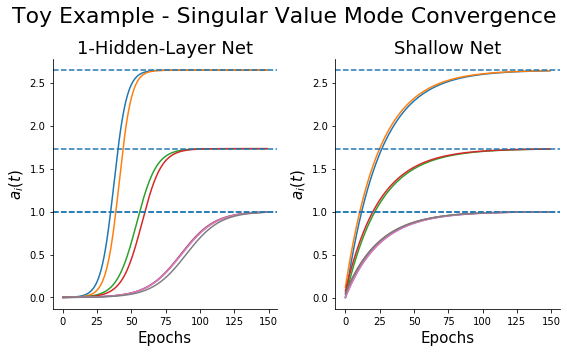

In [9]:
s_vals_deep_ana, s_vals_deep_emp = train_1hidden_net(num_hiddens, dt, num_epochs, tau, a_0, init_var=0.01)
s_vals_shallow_ana, s_vals_shallow_emp = train_shallow_net(dt, num_epochs, tau, a_0, init_var=0.01)
plot_figure3(s_vals_deep_ana, s_vals_deep_emp, s_vals_shallow_ana, s_vals_shallow_emp, s)

# Exc 2: Deeper Non-Linear Networks w. AutoDiff (8 Points)
In the following we analyze whether or not the theory does generalize to deeper networks as well as to networks with non-linearities.

Structure of the code:
1. Implement a variable Depth Linear Network $\to$ **1 Point**
2. Complement the Linear Deeper Net learning loop
    - Reshuffle the data & Perform forward evaluation $\to$ **1 Point**
    - Perform backward pass & SGD step $\to$ **1 Point**
3. Instantiate all required parts, run the loop and plot the singular values
    - Instantiate + Run loop $\to$ **1 Point**
    - Plot singular values $\to$ **1 Point**
4. Add ReLU non-linearities
    - Redefine network architecture + Rerun the network $\to$ **1 Point**
    - Replot the convergence behavior $\to$ **1 Point**
    - Interpret the results between linear & non-linear + deeper networks $\to$ **1 Point**

# Generating more artificial data - Branching Diffusion Process

In [10]:
class DiffuseTreeSampler():
    def __init__(self, num_features, tree_depth, branching_factor, sample_epsilon):
        self.num_features = num_features
        self.num_examples = branching_factor**tree_depth
        self.tree_depth = tree_depth
        self.branching_factor = branching_factor
        self.sample_epsilon = sample_epsilon
    
    def sample_feature(self):
        samples_per_tree_layer = [self.branching_factor**i for i in range(1, self.tree_depth+1)] 
        feature_tree = [np.random.choice([-1, 1], p=[0.5, 0.5], size=1)]
        for l in range(self.tree_depth):
            switch = np.random.choice([-1, 1],
                                      p=[self.sample_epsilon, 1-self.sample_epsilon],
                                      size=samples_per_tree_layer[l])
            next_layer = np.repeat(feature_tree[-1], self.branching_factor)
            feature_tree.append(next_layer*switch)
        return feature_tree[-1]
    
    def sample_data(self):
        """
        Each feature diffuses independently of the others!
        Sample them in sequence - but could parallelize - don't bother for now
        """
        features = []
        for feat in range(self.num_features):
            feature_temp = self.sample_feature()
            features.append(feature_temp)
        
        features_out = np.array(features).T
        items_out = np.diag(np.ones(self.num_examples))
        return features_out, items_out

In [11]:
hierarchical_tree = DiffuseTreeSampler(num_features=100, tree_depth=3,
                                       branching_factor=4, sample_epsilon=0.5)
features, items = hierarchical_tree.sample_data()

print("Output Dimensions: {}".format(features.shape))
print("Input Dimensions: {}".format(items.shape))

Output Dimensions: (64, 100)
Input Dimensions: (64, 64)


# Deeper Networks with Automatic Differentiation (PyTorch)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

Define the variable depth Deep Linear Network architecture with & without different non-linearities/activation /transfer functions. 

In [13]:
class DeepLinearNet(nn.Module):
    """
    Class for a variable sized Linear Network
    Inputs: Input Array Dimensions, Output Array Dimensions, List of Hidden Units for all Layers
    """
    def __init__(self, input_dim, output_dim, hidden_units=[], non_lin=None):
        super(DeepLinearNet, self).__init__()
        self.num_hidden_layers = len(hidden_units)
        layers = OrderedDict()
        
        # If list of hidden units is greater than one - loop to define linear layers
        if self.num_hidden_layers > 0:
            # Define Input Layer
            layers["0"] = nn.Linear(input_dim, hidden_units[0], bias=False)
            if non_lin == "ReLU":
                layers["0-act"] = nn.ReLU()
            elif non_lin == "Sigmoid":
                layers["0-act"] = nn.Sigmoid()
            elif non_lin == "Tanh":
                layers["0-act"] = nn.Tanh()
            # Define Hidden Layers in Loop
            for l in range(1, self.num_hidden_layers):
                layers[str(l)] = nn.Linear(hidden_units[l-1], hidden_units[l], bias=False)
                if non_lin == "ReLU":
                    layers[str(l) + "-act"] = nn.ReLU()
                elif non_lin == "Sigmoid":
                    layers[str(l) + "-act"] = nn.Sigmoid()
                elif non_lin == "Tanh":
                    layers[str(l) + "-act"] = nn.Tanh()
        # Otherwise define the shallow network
        else:
            hidden_units = [input_dim]
        # Define Output Layer
        layers[str(self.num_hidden_layers)] = nn.Linear(hidden_units[-1], output_dim, bias=False)
        self.model = nn.Sequential(layers)
        
    def forward(self, input_array):
        # Propagate the input through the linear network
        return self.model(input_array.float())

In [14]:
# Define the Online Gradient Descent Training Loop
def linear_net_learning(deep_net, mse_loss, optimizer, num_epochs, train_items, train_features):
    loss_log = []
    log_singular_vals = []
    num_points = train_items.shape[0]

    for epoch in range(num_epochs):
        epoch_loss = 0
        ids = np.arange(num_points)
        np.random.shuffle(ids)
        train_items = train_items[ids]
        train_features = train_features[ids]
        
        # Loop over all examples in an Online SGD Loop
        for t in range(num_points):
            input_tensor = torch.tensor(train_items[t])
            y_true = torch.tensor(train_features[t]).float()
            y_hat = deep_net(input_tensor)
            loss = mse_loss(y_hat, y_true)
            deep_net.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Log the loss & the from the predictions resulting singular values
        loss_log.append(epoch_loss/num_points)
        y_hat_full = deep_net(torch.tensor(train_items)).detach().numpy()
        U, s, V = svd(y_hat_full.T, full_matrices=True)
        log_singular_vals.append(s)
    return loss_log, np.array(log_singular_vals)

In [15]:
"""
Setup the Linear Network Training
    - Generate the toy dataset
    - Compute the "true" underlying SVD
    - Initialize a network, optimizer, MSE loss
"""
hierarchical_tree = DiffuseTreeSampler(num_features=100, tree_depth=3,
                                       branching_factor=3, sample_epsilon=0.5)
features, items = hierarchical_tree.sample_data()
input_dim, output_dim = items.shape[1], features.shape[1]

SIGMA_YX = features.T @ items
U, s, V = svd(SIGMA_YX, full_matrices=True)

In [16]:
l_rate = 0.5

shallow_lin_net = DeepLinearNet(input_dim, output_dim)
shallow_optimizer = optim.SGD(shallow_lin_net.parameters(), lr=l_rate)

deep_lin_net = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
lin_optimizer = optim.SGD(deep_lin_net.parameters(), lr=l_rate)

deep_relu_net = DeepLinearNet(input_dim, output_dim, [64, 128, 128], non_lin="ReLU")
relu_optimizer = optim.SGD(deep_relu_net.parameters(), lr=l_rate)

mse_loss = nn.MSELoss()

print(deep_lin_net)
print(deep_relu_net)

DeepLinearNet(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=False)
    (1): Linear(in_features=64, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=100, bias=False)
  )
)
DeepLinearNet(
  (model): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=False)
    (0-act): ReLU()
    (1): Linear(in_features=64, out_features=128, bias=False)
    (1-act): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (2-act): ReLU()
    (3): Linear(in_features=128, out_features=100, bias=False)
  )
)


## Non-Linear Networks - Comparing Shallow, Linear & ReLU Architectures

In [17]:
# Run the learning loops (shallow/linear/ReLU)
num_epochs = 1000
loss_log_shallow, log_s_vals_shallow = linear_net_learning(shallow_lin_net, mse_loss, shallow_optimizer, num_epochs, items, features)
loss_log_linear, log_s_vals_linear = linear_net_learning(deep_lin_net, mse_loss, lin_optimizer, 200, items, features)
loss_log_relu, log_s_vals_relu = linear_net_learning(deep_relu_net, mse_loss, relu_optimizer, 200, items, features)

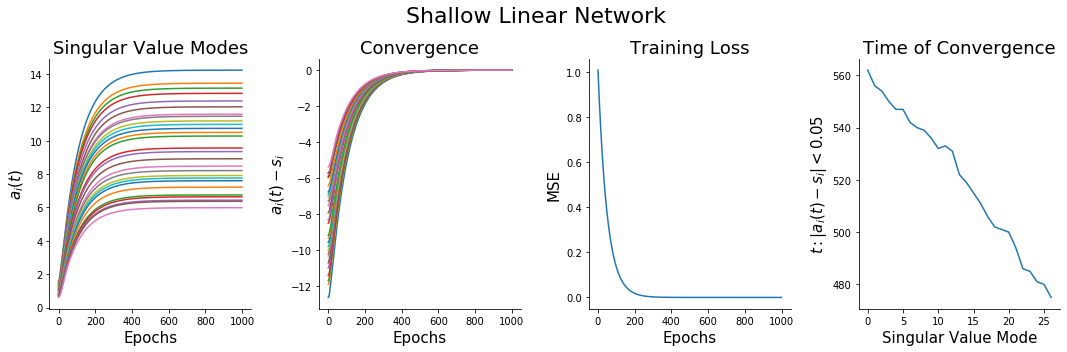

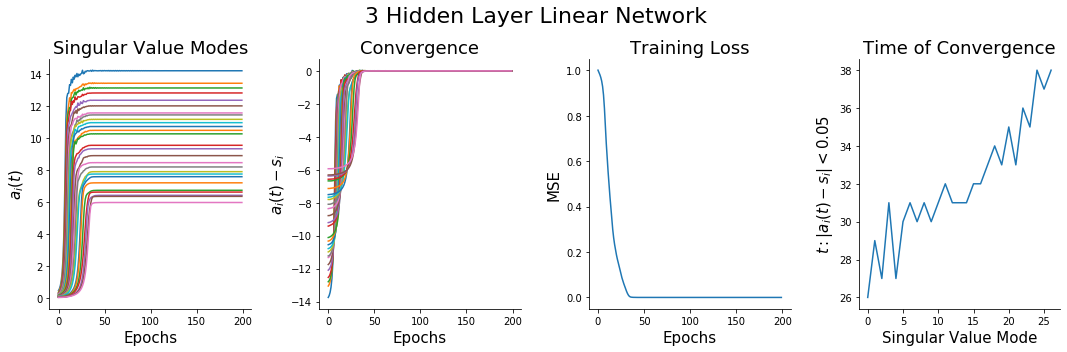

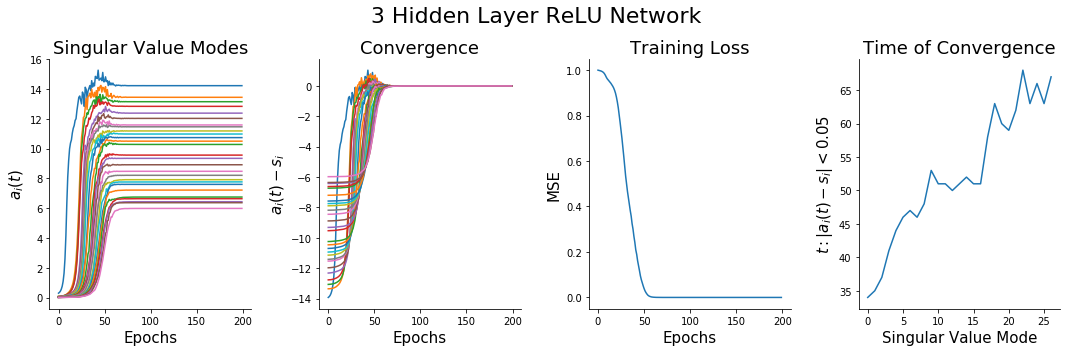

In [18]:
#Plot the results - Shallow/Linear/ReLU Network 
axs_shallow = plot_singular_val_dynamics(log_s_vals_shallow, loss_log_shallow, s, title='Shallow Linear Network')
axs_linear = plot_singular_val_dynamics(log_s_vals_linear, loss_log_linear, s, title='3 Hidden Layer Linear Network')
axs_relu = plot_singular_val_dynamics(log_s_vals_relu, loss_log_relu, s, title='3 Hidden Layer ReLU Network')

## Optimization Algorithm - Comparing SGD, Adam & RMSprop

In [19]:
# Define the networks & Optimizer
deep_lin_sgd = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
sgd_optimizer = optim.SGD(deep_lin_sgd.parameters(), lr=0.1)

deep_lin_adam = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
adam_optimizer = optim.Adam(deep_lin_adam.parameters(), lr=0.001)

deep_lin_rms = DeepLinearNet(input_dim, output_dim, [64, 128, 128])
rmsprop_optimizer = optim.RMSprop(deep_lin_rms.parameters(), lr=0.001)

In [20]:
# Run the learning loops (SGD/Adam/RMSprop)
num_epochs = 500
loss_log_sgd, log_s_vals_sgd = linear_net_learning(deep_lin_sgd, mse_loss, sgd_optimizer, num_epochs, items, features)
loss_log_adam, log_s_vals_adam = linear_net_learning(deep_lin_adam, mse_loss, adam_optimizer, num_epochs, items, features)
loss_log_rms, log_s_vals_rms = linear_net_learning(deep_lin_rms, mse_loss, rmsprop_optimizer, num_epochs, items, features)

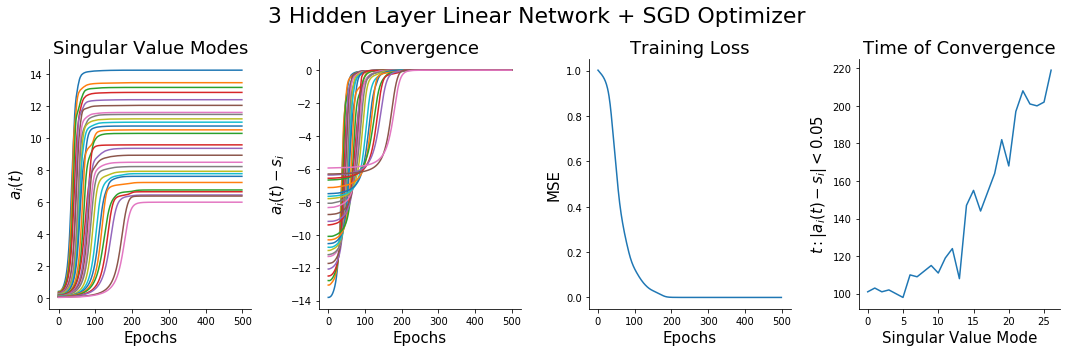

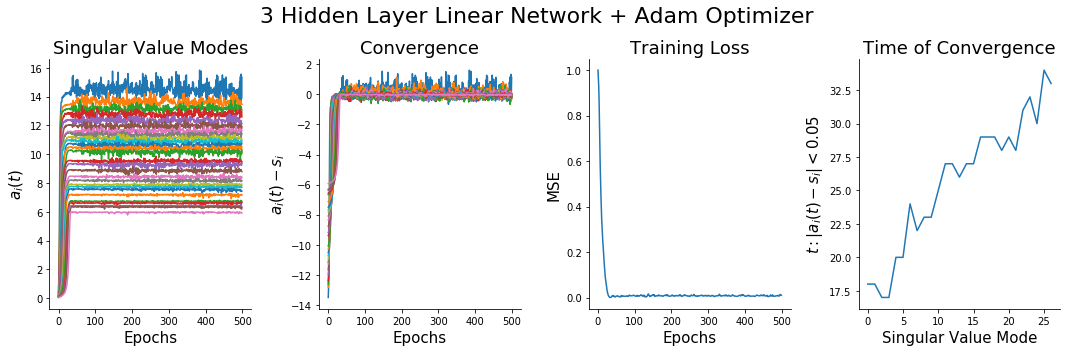

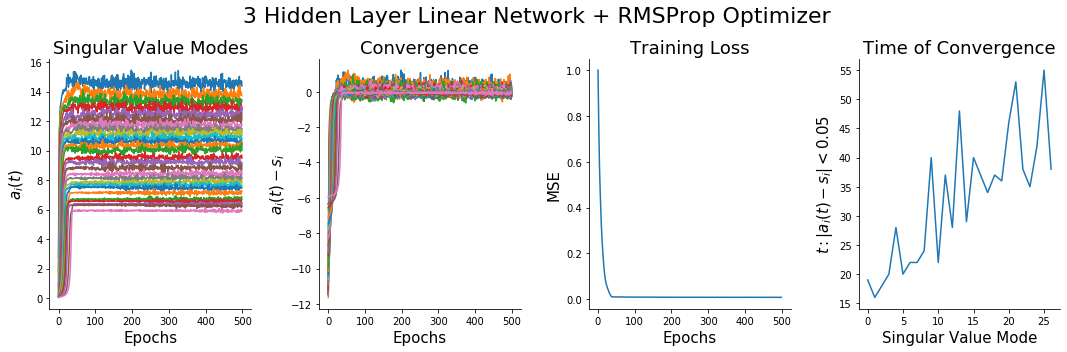

In [21]:
#Plot the results - Linear Network with SGD/Adam/RMSProp
axs_sgd = plot_singular_val_dynamics(log_s_vals_sgd, loss_log_sgd, s, title='3 Hidden Layer Linear Network + SGD Optimizer')
axs_adam = plot_singular_val_dynamics(log_s_vals_adam, loss_log_adam, s, title='3 Hidden Layer Linear Network + Adam Optimizer')
axs_rms = plot_singular_val_dynamics(log_s_vals_rms, loss_log_rms, s, title='3 Hidden Layer Linear Network + RMSProp Optimizer')

# Marks - WS 2019/2020

1. Céline Budding, Dorothea Müller 9 + 8 = 17
2. Rosa Zimmermann, Saeed Salehinajafabadi  9 + 8 = 17
3. Blickensdörfer & Chebykin  9.5 + 7.5 = 17
4. Malkawi & Melkonyan   8 + 5 = 13
5. Matory & Braun 9.5 + 8 = 17.5
6. Eliana Alejandra Bohorquez Puentes, Marc Büttner 9 + 7 = 16 
7. Gabriel Wagner vom Berg and Hymavathy Balasubramanian 9.5 + 8 = 17.5
8. Andi Gerken 9 + 8 = 17
9. Viet Nguyen Hoang 9.5 + 8 = 17.5
10. Parvathy Neelakandan, Zainab Mohamed 9 + 8 = 17